<a href="https://colab.research.google.com/github/jphillips-0280/MachineLearning/blob/main/JulesPhillipsHw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.(15 pts.) You are provided with a dataset of different aircraft that includes three columns:

Aircraft (string; not used in clustering),
Speed_kmh (cruise speed in km/h), and
FuelFlow_kgph (cruise fuel flow in kg/hour for the whole aircraft).

Using only the numeric features Speed_kmh and FuelFlow_kgph, apply k-means clustering to group the aircraft into meaningful performance categories. Be sure to standardize the features (for example, with StandardScaler) before clustering. For values of k from 2 to 6, compute the silhouette score and plot the score as a function of k. Based on your plot, select a reasonable value of k, fit k-means, and create a scatter plot of cruise speed versus fuel flow where points are colored according to their assigned cluster. Finally, briefly interpret each cluster in engineering terms, for example, “fast and high fuel flow corresponds to jets,” while “slower and very low fuel flow corresponds to general aviation aircraft.” As an optional step, you may label a few representative aircraft on your plot to make the clusters more interpretable.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks

Best silhouette score: 0.7945 at k = 4


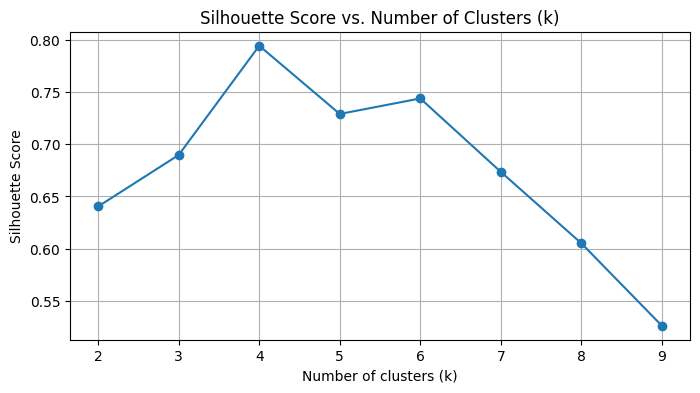

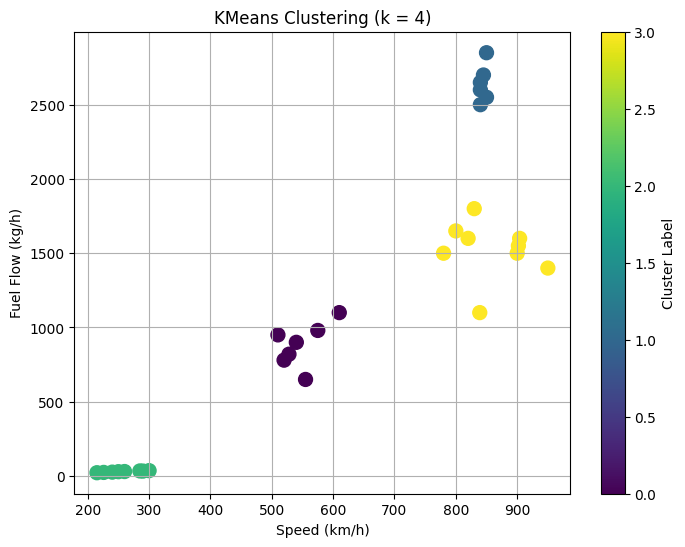

Lowest silhouette score: 0.7945 occurs at k = 4


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from google.colab import drive
from google.colab import files

# Mount Google Drive
drive.mount('/content/drive')
# Go to the current folder
%cd /content/drive/MyDrive/Colab Notebooks/

# Load the dataset into a pandas DataFrame
df = pd.read_csv('aircraft_performance.csv')

# --- Select Features for Clustering ---
features = ['Speed_kmh', 'FuelFlow_kgph']
X = df[features].to_numpy()

# --- Feature Scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Try Different k Values for Silhouette Score ---
silhouette_scores = []
k_values = range(2, 10)  # You can go up to 20, but 2–10 is often enough

for k in k_values:
    kmeans = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=10,
        max_iter=300,
        random_state=42
    )
    labels = kmeans.fit_predict(X_scaled)

    if len(set(labels)) > 1:  # At least 2 clusters
        score = silhouette_score(X_scaled, labels)
    else:
        score = -1

    silhouette_scores.append(score)

# --- Find Best k ---
best_score = max(silhouette_scores)
best_k = k_values[silhouette_scores.index(best_score)]

print(f"\nBest silhouette score: {best_score:.4f} at k = {best_k}")

# --- Final KMeans with Best k ---
final_kmeans = KMeans(
    n_clusters=best_k,
    init='k-means++',
    n_init=10,
    max_iter=300,
    random_state=42
)
cluster_labels = final_kmeans.fit_predict(X_scaled)

# --- Add Cluster Labels to Original Data ---
df['Cluster'] = cluster_labels

# --- Plot Silhouette Scores ---
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
plt.title("Silhouette Score vs. Number of Clusters (k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# --- Plot Clusters ---
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df['Speed_kmh'], df['FuelFlow_kgph'],
    c=df['Cluster'], cmap='viridis', s=100
)
plt.title(f"KMeans Clustering (k = {best_k})")
plt.xlabel("Speed (km/h)")
plt.ylabel("Fuel Flow (kg/h)")
plt.colorbar(scatter, label="Cluster Label")
plt.grid(True)
plt.show()

# --- calculating max silhouette score at which k to use
max_score = max(silhouette_scores)
max_k = range(2, 10)[silhouette_scores.index(max_score)]
print(f'Lowest silhouette score: {max_score:.4f} occurs at k = {max_k}')

2. (40 pts.) Implement your own linear machine learning model optimized with mini-batch gradient descent method to predict the price of a house in a city with population of 160,000. Train the model to fit the housing prices dataset found on LMS. Vary the batch size from 1, 5, 10, and 20. Plot the objective function, J for each batch size. You do not need to split the data into train and test set for this problem. What happens when you use batch size equal to one?

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks
Batch size 1: final cost = 8.9808, w = 4.5486, b = 5.6815
Batch size 5: final cost = 8.9552, w = 4.6263, b = 5.8491
Batch size 10: final cost = 8.9552, w = 4.6118, b = 5.8093
Batch size 20: final cost = 8.9540, w = 4.5936, b = 5.8357


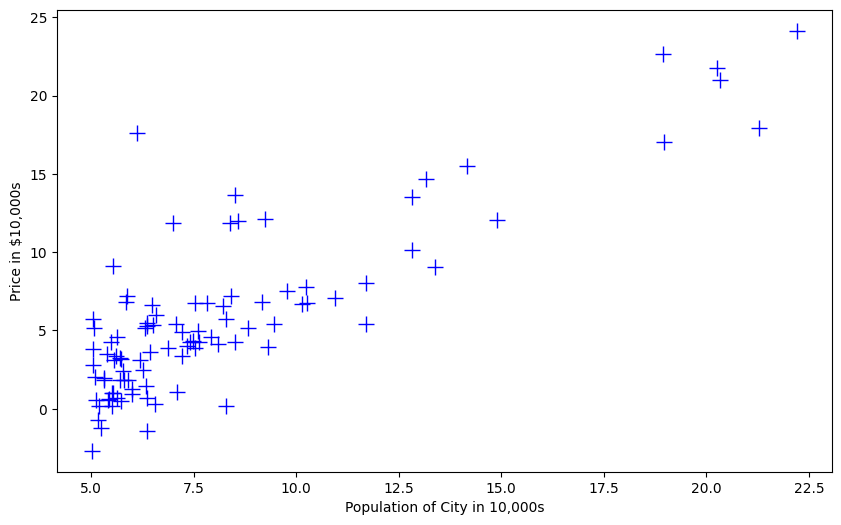

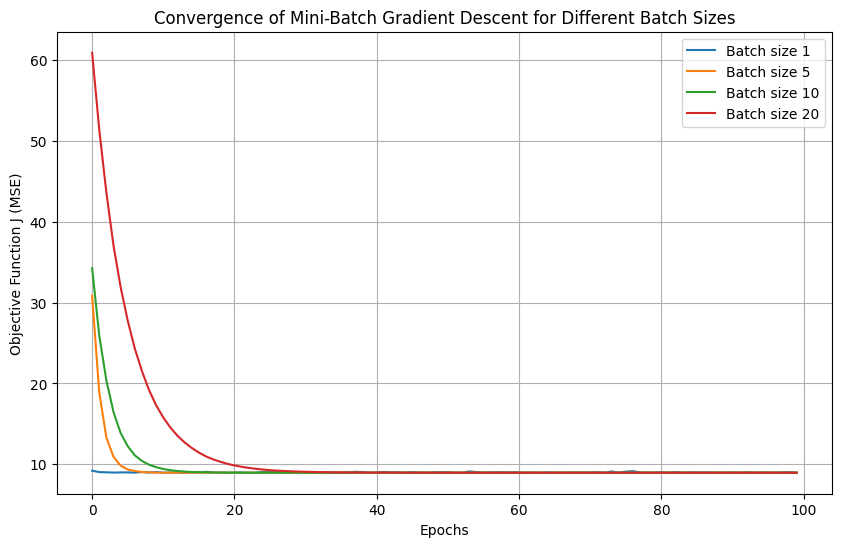

Predicted house price for population 160,000: 151905.29 USD


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files

# Mount Google Drive
drive.mount('/content/drive')
# Go to the current folder
%cd /content/drive/MyDrive/Colab Notebooks/


%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm
import itertools

houseprices = 'housing_prices.csv'
cols = np.loadtxt(houseprices,delimiter=',',usecols=(0,1),unpack=True)
X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
m = y.size
X = np.insert(X,0,1,axis=1)

# ----- plotting raw data -----
plt.figure(figsize=(10,6))
plt.plot(X[:,1],y[:,0],'b+',markersize=12)
plt.xlabel('Population of City in 10,000s')
plt.ylabel('Price in $10,000s')

# --- mini batch gradient descent implementation ---

# ---------------------------
# 1. Load your data
# ---------------------------
# Assuming your dataset is two columns: population, price
data = np.loadtxt("housing_prices.csv", delimiter=",")
X = data[:, 0].reshape(-1, 1)
y = data[:, 1].reshape(-1, 1)

# Normalize X for better convergence
X = (X - np.mean(X)) / np.std(X)

# ---------------------------
# 2. Initialize parameters
# ---------------------------
np.random.seed(0)
w = np.random.randn(1)
b = np.random.randn(1)
learning_rate = 0.01
epochs = 100

# ---------------------------
# 3. Mini-batch Gradient Descent Function
# ---------------------------
def mini_batch_gd(X, y, batch_size):
    m = len(X)
    w, b = np.random.randn(1), np.random.randn(1)
    cost_history = []

    for epoch in range(epochs):
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            y_pred = w * X_batch + b
            error = y_pred - y_batch

            dw = (2 / len(X_batch)) * np.sum(error * X_batch)
            db = (2 / len(X_batch)) * np.sum(error)

            w -= learning_rate * dw
            b -= learning_rate * db

        # Record cost for visualization
        y_pred_all = w * X + b
        cost = np.mean((y_pred_all - y) ** 2)
        cost_history.append(cost)

    return w, b, cost_history

# ---------------------------
# 4. Train for different batch sizes
# ---------------------------
batch_sizes = [1, 5, 10, 20]
results = {}

for batch_size in batch_sizes:
    w, b, cost_hist = mini_batch_gd(X, y, batch_size)
    results[batch_size] = cost_hist
    print(f"Batch size {batch_size}: final cost = {cost_hist[-1]:.4f}, w = {w[0]:.4f}, b = {b[0]:.4f}")

# ---------------------------
# 5. Plot objective function J for each batch size
# ---------------------------
plt.figure(figsize=(10,6))
for batch_size, cost_hist in results.items():
    plt.plot(cost_hist, label=f"Batch size {batch_size}")
plt.xlabel("Epochs")
plt.ylabel("Objective Function J (MSE)")
plt.title("Convergence of Mini-Batch Gradient Descent for Different Batch Sizes")
plt.legend()
plt.grid(True)
plt.show()


x_new = 16  # population of 160,000
# Normalize the new input using the mean and standard deviation from the training data
x_new_scaled = (x_new - np.mean(data[:, 0])) / np.std(data[:, 0])
# Use the weights and bias from the last trained model (batch size 20)
y_pred = w * x_new_scaled + b
print(f"Predicted house price for population 160,000: {float(y_pred[0])*10000:.2f} USD")

3. (20 pts.) Use the Scikit-learn breast cancer Wisconsin dataset and a logistic regression model to classify breast cancers. You must recursively eliminate features to find the best two features to perform the classification. Evaluate the model using various classification metrics and report your findings. Use a 70%-30% split.

Selected features: ['worst radius', 'worst concavity']

Model Performance:
Accuracy:  0.9298
Precision: 0.9130
Recall:    0.9813
F1-score:  0.9459

Classification Report:
              precision    recall  f1-score   support

   malignant       0.96      0.84      0.90        64
      benign       0.91      0.98      0.95       107

    accuracy                           0.93       171
   macro avg       0.94      0.91      0.92       171
weighted avg       0.93      0.93      0.93       171



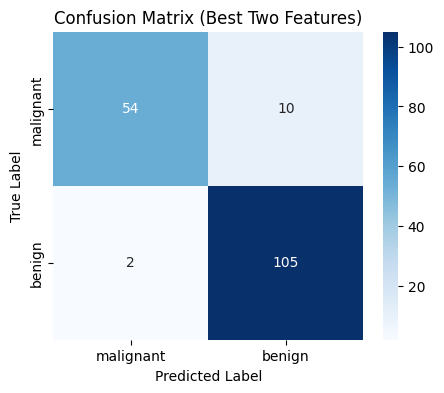

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1. Load dataset
# --------------------------
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# --------------------------
# 2. Train-test split (70/30)
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --------------------------
# 3. Logistic Regression model
# --------------------------
log_reg = LogisticRegression(max_iter=10000, solver='liblinear')

# --------------------------
# 4. Recursive Feature Elimination (RFE)
# --------------------------
rfe = RFE(estimator=log_reg, n_features_to_select=2)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
print("Selected features:", list(selected_features))

# --------------------------
# 5. Train model on best two features
# --------------------------
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

log_reg.fit(X_train_rfe, y_train)
y_pred = log_reg.predict(X_test_rfe)

# --------------------------
# 6. Evaluate performance
# --------------------------
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=data.target_names))

# --------------------------
# 7. Confusion Matrix
# --------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Best Two Features)')
plt.show()


4. (25 pts.) Construct a neural network with a single hidden layer containing two neurons using Tensorflow. Use ReLU as activation function. Optimize the network with stochastic gradient descent method. Choose mean squared error to calculate the loss. Fit the housing prices dataset found on LMS using the network. Use the trained neural network model to predict the price of a house in a city with population of 165,000. Calculate a useful regression metric. Plot the training and validation losses. Use a 70%-30% split for the training and validation dataset. The architecture of the neural network and the optimizer are fixed for this problem. Therefore, you need to choose a suitable learning rate and number of epochs to minimize the loss. Explain the trends you found in the plots for training and validation losses.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


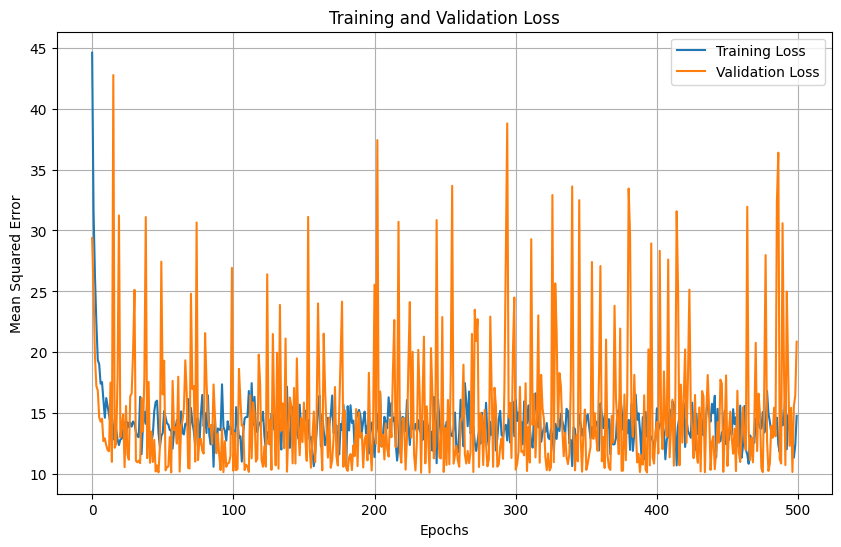

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted house price for population 165,000: $181,825.87
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Validation RMSE: $45,691.53
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/tmp/ipython-input-2179293441.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_price = float(y_pred) * 10000


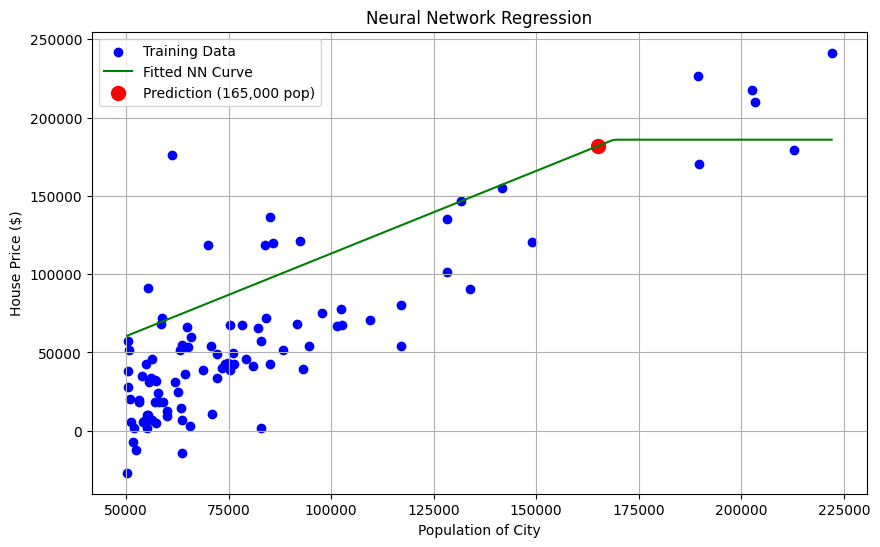

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --------------------------
# 1. Load dataset
# --------------------------
# Replace "housing_prices.txt" with your actual dataset path
data = np.loadtxt("housing_prices.csv", delimiter=",")
X = data[:, 0].reshape(-1, 1)  # Population (in 10,000s)
y = data[:, 1].reshape(-1, 1)  # Price (in $10,000s)

# --------------------------
# 2. Train-validation split (70%-30%)
# --------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# --------------------------
# 3. Normalize features
# --------------------------
X_mean, X_std = np.mean(X_train), np.std(X_train)
X_train_norm = (X_train - X_mean) / X_std
X_val_norm = (X_val - X_mean) / X_std

# --------------------------
# 4. Build the neural network
# --------------------------
model = tf.keras.Sequential([
    tf.keras.layers.Dense(2, activation='relu', input_shape=(1,)),  # hidden layer
    tf.keras.layers.Dense(1)  # output layer
])

learning_rate = 0.01  # can tune slightly
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')

# --------------------------
# 5. Train the model
# --------------------------
epochs = 500
history = model.fit(
    X_train_norm, y_train,
    validation_data=(X_val_norm, y_val),
    epochs=epochs,
    batch_size=1,  # stochastic gradient descent
    verbose=0
)

# --------------------------
# 6. Plot training and validation loss
# --------------------------
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# --------------------------
# 7. Predict for population = 165,000
# --------------------------
x_new = 165000 / 10000  # convert to same units as dataset
x_new_norm = (x_new - X_mean) / X_std

y_pred = model.predict(np.array([[x_new_norm]]))
predicted_price = float(y_pred) * 10000
print(f"Predicted house price for population 165,000: ${predicted_price:,.2f}")

# --------------------------
# 8. Calculate RMSE on validation set
# --------------------------
y_val_pred = model.predict(X_val_norm)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred)) * 10000
print(f"Validation RMSE: ${rmse:,.2f}")

# --------------------------
# 9. Plot fitted curve + prediction point
# --------------------------
# Generate smooth population values for plotting
X_plot = np.linspace(min(X), max(X), 200).reshape(-1, 1)
X_plot_norm = (X_plot - X_mean) / X_std
y_plot = model.predict(X_plot_norm) * 10000  # scale back to dollars

plt.figure(figsize=(10,6))
plt.scatter(X * 10000, y * 10000, color='blue', label='Training Data')
plt.plot(X_plot * 10000, y_plot, color='green', label='Fitted NN Curve')
plt.scatter(x_new * 10000, predicted_price, color='red', s=100, label='Prediction (165,000 pop)')
plt.xlabel('Population of City')
plt.ylabel('House Price ($)')
plt.title('Neural Network Regression')
plt.legend()
plt.grid(True)
plt.show()
